<a href="https://colab.research.google.com/github/Ice-CreamAT/GeneticAlgorithms/blob/main/GeneticAlgorIthms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INSTALL DEPENDENCIES**

In [ ]:
!pip install deap --quiet
!pip install livelossplot --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 4.5 MB/s eta 0:00:00


# **IMPORT LIBS**

In [ ]:
import os
import time                                  # Add pauses between iterations.
import math                                  # Mathematical operations.
import numpy as np                           # Manipulation of matrices and mathematical operations.
import random                                # Random numbers.
import matplotlib.pyplot as plt              # Graphs.
import matplotlib.animation as manimation    # (animation)
import pandas as pd                          # Structured data manipulation.
import seaborn as sns                        # Statistical data visualization.
import tqdm.notebook as nb                   # Progress bars
import tensorflow as tf                      # Deep learning
import sklearn.datasets                      # Datasets
import sklearn.linear_model                  # Linear/Logistic Regression Models

from deap import algorithms
from deap import base
from deap import benchmarks
from deap import creator
from deap import tools

from tensorflow import keras
from sklearn.metrics import classification_report           # Metrics
from sklearn.model_selection import train_test_split        # Divide into training and testing
from sklearn.preprocessing import StandardScaler            # Standardize the data
from IPython.display import clear_output                    # Clear output after each iteration.
from livelossplot import PlotLosses                         # Live loss plots.

# **GAME OF LIFE**

In [ ]:
def life(X, steps):
    def roll_it(x, y):
        return np.roll(np.roll(X, y, axis=0), x, axis=1)
    for _ in range(steps):
        # the universe is considered toroidal
        Y = roll_it(1, 0) + roll_it(0, 1) + roll_it(-1, 0) \
            + roll_it(0, -1) + roll_it(1, 1) + roll_it(-1, -1) \
            + roll_it(1, -1) + roll_it(-1, 1)
        # rules
        X = np.logical_or(np.logical_and(X, Y ==2), Y==3)
        X = X.astype(int)
        yield X

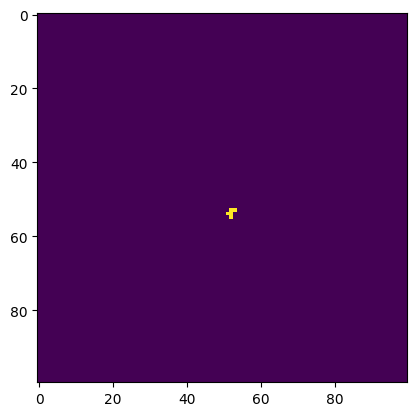

In [ ]:
X = np.zeros((100, 100)) # 100 by 100 dead cells
# R-Pentomino
X[53, 52:54] = 1
X[54, 51:53] = 1
X[55, 52] = 1
plt.imshow(X)
plt.show()

In [ ]:
FFMpegWriter = manimation.writers['ffmpeg']
writer = FFMpegWriter(fps=20)
fig = plt.figure()
fig.patch.set_facecolor('black')
with writer.saving(fig, "game_of_life.mp4", 200):
    plt.spy(X)
    plt.axis('off')
    writer.grab_frame()
    plt.clf()
    for x in nb.tqdm(life(X, 800),total=800):
        plt.spy(x)
        plt.axis('off')
        writer.grab_frame()
        plt.clf()

  0%|          | 0/800 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

# **GENETIC ALGORITHMS**

In [ ]:
def create_cell():
 return dict(health = random.randint(1, 100))

In [ ]:
def birth(offspring):
 return [create_cell() for i in range(offspring)]

In [ ]:
cells = birth(10)
print(cells)

[{'health': 46}, {'health': 22}, {'health': 54}, {'health': 32}, {'health': 1}, {'health': 9}, {'health': 32}, {'health': 22}, {'health': 42}, {'health': 24}]


In [ ]:
#@title Dataset Parameters  { run: "auto" }
rprd_rate = 50                   #@param {type:"slider", min:1, max:50, step:1}
death_rate = 25                  #@param {type:"slider", min:1, max:25, step:1}
initial_offspring = 10           #@param {type:"slider", min:1, max:25, step:1}
population = 50                  #@param {type:"slider", min:1, max:50, step:1}
genes = 100                      #@param {type:"slider", min:1, max:100, step:1}
mutate_rate = 10                 #@param {type:"slider", min:1, max:25, step:1}
mutate_range = 5                 #@param {type:"slider", min:1, max:25, step:1}
generations = 30                 #@param {type:"slider", min:1, max:50, step:1}

In [ ]:
rprd_bounds = (0.5, 1.0)
death_bounds = (0.0, 0.2)

In [ ]:
def reproduce(cells):
 return [create_cell() for cell in cells if random.randint(1, 100) < rprd_rate]
def death(cells):
 return [cell for cell in cells if random.randint(1, 100) > death_rate]
def run_generation(cells):
 cells.extend(reproduce(cells))
 return death(cells)

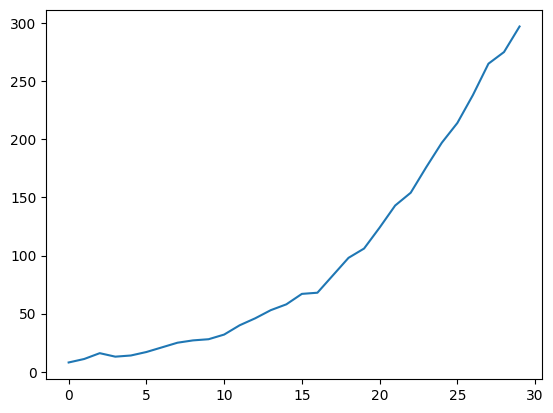

In [ ]:
cells = birth(initial_offspring)
history = []
for i in range(generations):
 cells = run_generation(cells)
 history.append(len(cells))
 clear_output()
 plt.plot(history)
 plt.show()
 time.sleep(1)

In [ ]:
def create_cell():
 return dict(
 health = random.randint(1, 100),
 strength = random.randint(1, 100)
 )
def birth(offspring):
 return [create_cell() for i in range(offspring)]
def evaluate(cells):
 for cell in cells:
  cell["health"] *= cell["strength"]/100
  return cells

In [ ]:
def reproduce(cells):
 return [create_cell() for cell in cells if rprd_bounds[0] <= cell["health"] <= rprd_bounds[1]]
def death(cells):
 return [create_cell() for cell in cells if cell["health"] > rprd_bounds[0]]
def run_generation(cells):
 cells = evaluate(cells)
 cells.extend(reproduce(cells))
 return death(cells)

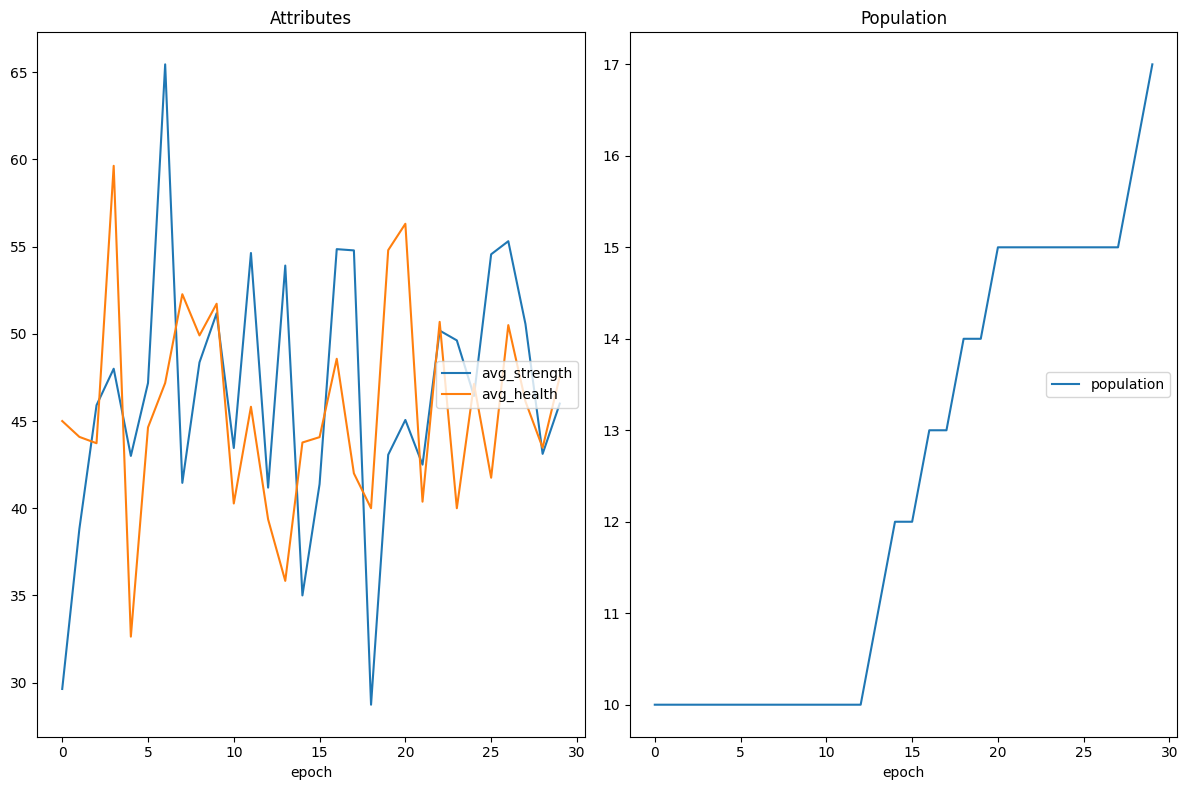

Attributes
	avg_strength     	 (min:   28.733, max:   65.455, cur:   46.000)
	avg_health       	 (min:   32.636, max:   59.636, cur:   47.556)
Population
	population       	 (min:   10.000, max:   17.000, cur:   17.000)


In [ ]:
cells = birth(initial_offspring)
groups = {'Population': ['population'], 'Attributes' : ['avg_strength','avg_health']}
liveloss = PlotLosses(groups=groups)
history = {}
for i in range(generations):
  cells = run_generation(cells)
  history["population"] = len(cells)
  history["avg_strength"] = sum([cell["strength"] for cell in
                                 cells])/(len(cells)+1)
  history["avg_health"] = sum([cell["health"] for cell in
  cells])/(len(cells)+1)
  liveloss.update(history)
  liveloss.send()

In [ ]:
def create_cell(parent1, parent2):
  if parent1 is None or parent2 is None:
    return dict(
        fitness = 0,
        a = random.randint(1, 100),
        b = random.randint(1, 100),
        c = random.randint(1, 100)
      )
  else:
    return dict(
        fitness = 0,
        a = (parent1["a"] + parent2["a"])/2,
        b = (parent1["b"] + parent2["b"])/2,
        c = (parent1["c"] + parent2["c"])/2,
      )

In [ ]:
def birth(offspring):
  return [create_cell(None, None) for i in range(offspring)]

In [ ]:
#@title Cells Parameters  { run: "auto" }
mutate_range = 20                #@param {type:"slider", min:1, max:25, step:1}
generations = 30                 #@param {type:"slider", min:1, max:50, step:1}

In [ ]:
def clamp(value, min_val, max_val):
    return max(min_val, min(value, max_val))

def mutate(cells):
    for cell in cells:
        if random.randint(1, 100) < mutate_rate:
            cell["a"] = clamp(cell["a"] + random.randint(-mutate_range, mutate_range), 1, 100)
            cell["b"] = clamp(cell["b"] + random.randint(-mutate_range, mutate_range), 1, 100)
            cell["c"] = clamp(cell["c"] + random.randint(-mutate_range, mutate_range), 1, 100)
    return cells


In [ ]:
def evaluate(cells):
    for cell in cells:
        cell["fitness"] = 2 * cell["a"] - cell["b"] + cell["c"]
    return cells

In [ ]:
def reproduce(cells):
    parents = sorted(cells, key=lambda d: d["fitness"])[int(len(cells) / 2):]
    children = []
    for _ in range(len(parents) * 2):
        mates = random.sample(parents, 2)
        children.append(create_cell(mates[0], mates[1]))
    return mutate(children)

In [ ]:
def run_generation(cells):
 cells = evaluate(cells)
 cells = reproduce(cells)
 cells = evaluate(cells)
 return cells

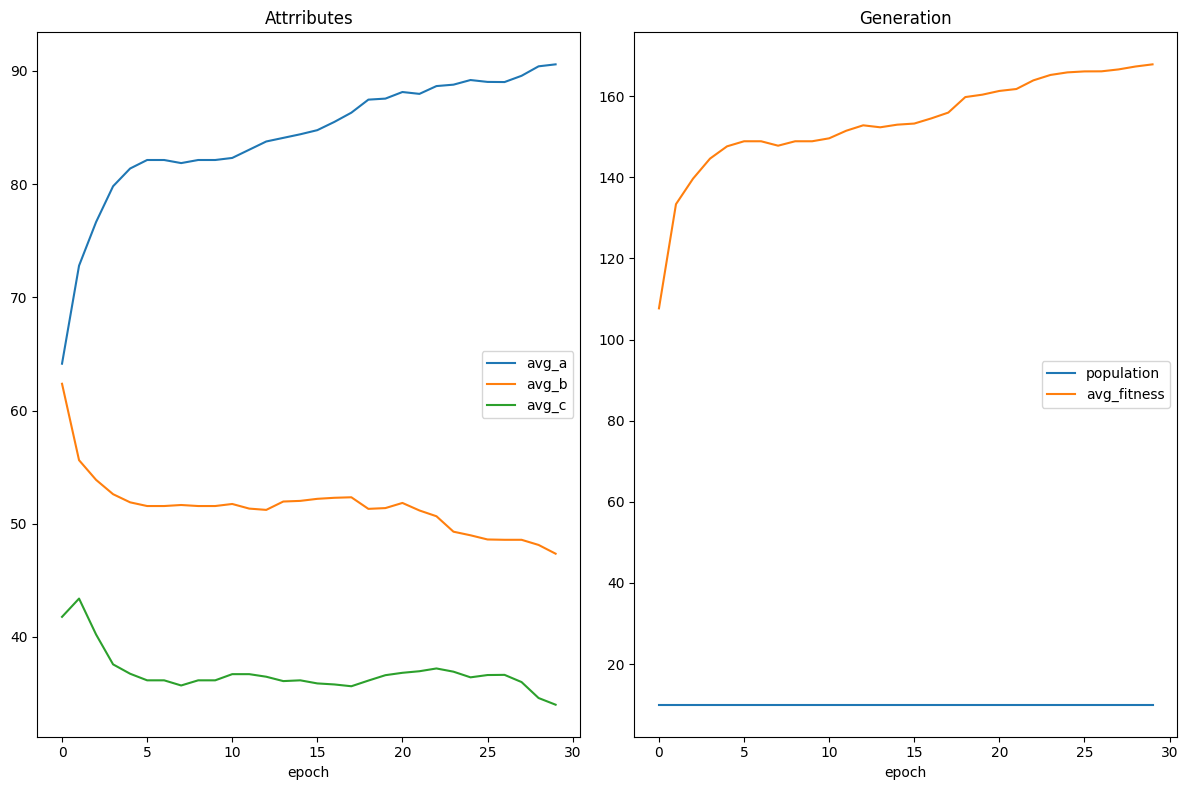

Attrributes
	avg_a            	 (min:   64.136, max:   90.580, cur:   90.580)
	avg_b            	 (min:   47.352, max:   62.364, cur:   47.352)
	avg_c            	 (min:   34.011, max:   43.386, cur:   34.011)
Generation
	population       	 (min:   10.000, max:   10.000, cur:   10.000)
	avg_fitness      	 (min:  107.682, max:  167.820, cur:  167.820)


In [ ]:
cells = birth(initial_offspring)

groups = {'Generation': ['population','avg_fitness'], 'Attrributes' : ["avg_a", "avg_b", "avg_c"]}
liveloss = PlotLosses(groups=groups)

history = {}
for i in range(generations):
  cells = run_generation(cells)
  history["population"] = len(cells)
  history["avg_fitness"] = sum([cell["fitness"] for cell in cells])/(len(cells)+1)
  history["avg_a"] = sum([cell["a"] for cell in cells])/(len(cells)+1)
  history["avg_b"] = sum([cell["b"] for cell in cells])/(len(cells)+1)
  history["avg_c"] = sum([cell["c"] for cell in cells])/(len(cells)+1)
  liveloss.update(history)
  liveloss.send()

# **DEEP LEARNING**

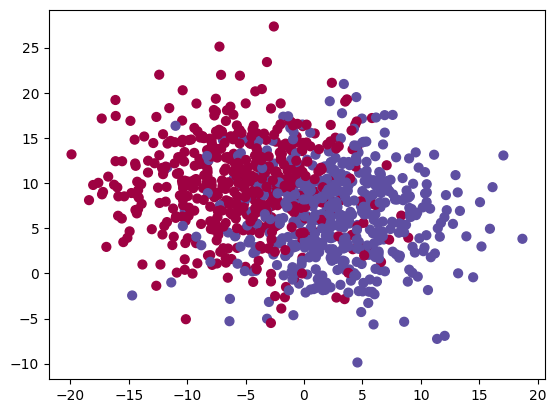

In [ ]:
#@title Dataset Parameters  { run: "auto" }
number_samples = 1000 #@param {type:"slider", min:100, max:1000, step:25}
difficulty = 5 #@param {type:"slider", min:1, max:5, step:1}
problem = "blobs" #@param ["classification", "blobs", "gaussian quantiles", "moons", "circles"]
number_features = 2
number_classes = 2
middle_layer = 25 #@param {type:"slider", min:5, max:25, step:1}

def load_data(problem):
  if problem == "classification":
    clusters = 1 if difficulty < 3 else 2
    informs = 1 if difficulty < 4 else 2
    data = sklearn.datasets.make_classification(
        n_samples = number_samples,
        n_features=number_features,
        n_redundant=0,
        class_sep=1/difficulty,
        n_informative=informs,
        n_clusters_per_class=clusters)

  if problem == "blobs":
    data = sklearn.datasets.make_blobs(
        n_samples = number_samples,
        n_features=number_features,
        centers=number_classes,
        cluster_std = difficulty)

  if problem == "gaussian quantiles":
    data = sklearn.datasets.make_gaussian_quantiles(mean=None,
                                                  cov=difficulty,
                                                  n_samples=number_samples,
                                                  n_features=number_features,
                                                  n_classes=number_classes,
                                                  shuffle=True,
                                                  random_state=None)

  if problem == "moons":
    data = sklearn.datasets.make_moons(
        n_samples = number_samples)

  if problem == "circles":
    data = sklearn.datasets.make_circles(
        n_samples = number_samples)

  return data

data = load_data(problem)
X, Y = data


# Input Data
plt.figure("Input Data")
plt.scatter(X[:, 0], X[:, 1], c=Y, s=40, cmap=plt.cm.Spectral)

In [ ]:
def show_predictions(model, X, Y, name=""):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    X_temp = np.c_[xx.flatten(), yy.flatten()]
    Z = model.predict(X_temp)
    plt.figure("Predictions " + name)
    plt.contourf(xx, yy, Z.reshape(xx.shape), cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[:, 0], X[:, 1],c=Y, s=40, cmap=plt.cm.Spectral)

Logistic Regression accuracy :  0.818


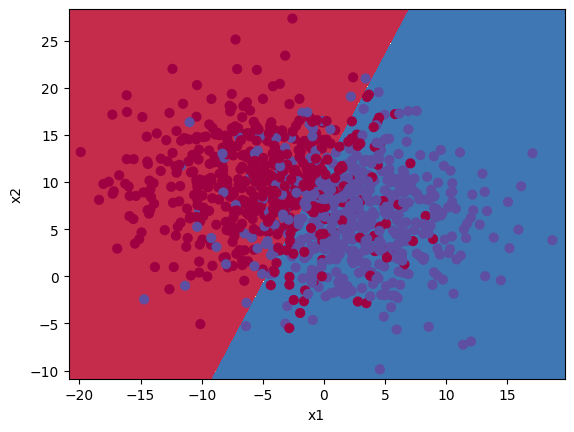

In [ ]:
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X, Y)

show_predictions(clf, X, Y, "Logistic regression")

LR_predictions = clf.predict(X)
print("Logistic Regression accuracy : ", np.sum(LR_predictions == Y) / Y.shape[0])

In [ ]:
housing = tf.keras.datasets.california_housing.load_data()
x_train, y_train = housing[0]
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)  # Split into train and test sets
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
print(f"Training: {x_train.shape}, Test: {x_test.shape}")

Training: (13209, 8), Test: (3303, 8)


# **FASHION_MNIST**

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
print(f"Training: {x_train.shape}, Test: {x_test.shape}")
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training: (60000, 28, 28), Test: (10000, 28, 28)


In [ ]:
#@title Keras {run: "auto"}
middle_layer = 128 #@param {type:"slider", min:16, max:128, step:2}
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(middle_layer, activation='relu'),
  tf.keras.layers.Dense(middle_layer, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=.001)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
trainableParams = np.sum([np.prod(v.shape) for v in model.trainable_weights])
print(f"Trainable parameters: {trainableParams}")

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_13 (Flatten)                 │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,282 (462.04 KB)

 Trainable params: 118,282 (462.04 KB)

 Non-trainable params: 0 (0.00 B)

Trainable parameters: 118282


In [ ]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

# **"TRADITIONAL" ALGORITHM**

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7726 - loss: 0.6536 - val_accuracy: 0.8523 - val_loss: 0.4153
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8657 - loss: 0.3705 - val_accuracy: 0.8627 - val_loss: 0.3890
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8803 - loss: 0.3333 - val_accuracy: 0.8681 - val_loss: 0.3636
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8855 - loss: 0.3100 - val_accuracy: 0.8756 - val_loss: 0.3480
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8923 - loss: 0.2894 - val_accuracy: 0.8741 - val_loss: 0.3435
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8942 - loss: 0.2813 - val_accuracy: 0.8794 - val_loss: 0.3400
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9011 - loss: 0.2650 - val_accuracy: 0.8784 - val_loss: 0.3398
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9046 - loss: 0.2558

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'Accuracy on test set: {test_acc:.4f}')

313/313 - 1s - 2ms/step - accuracy: 0.8891 - loss: 0.3255
Accuracy on test set: 0.8891


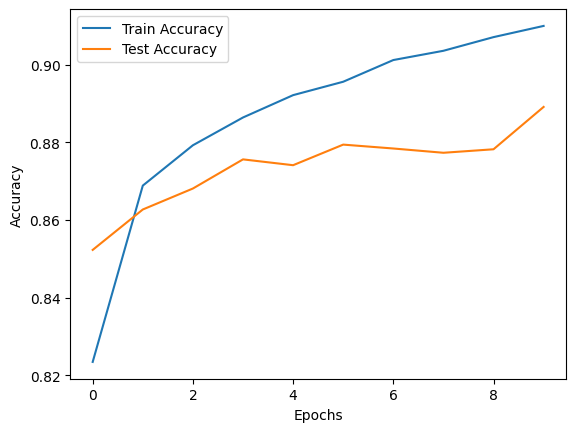

Accuracy: 0.8891


In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print(f'Accuracy: {test_acc:.4f}')

# **GENETIC ALGORITHM**

In [ ]:
def score_model():
  y_hat = model.predict(x_test)
  acc = [np.argmax(y)==y_test[i] for i,y in enumerate(y_hat)]
  return sum(acc)/len(acc)

def print_parameters():
  for layer in model.layers:
    for na in layer.get_weights():
      print(na)

def set_parameters(individual):
  idx = 0
  tensors=[]
  for layer in model.layers:
    for na in layer.get_weights():
      size = na.size
      sh = na.shape
      t = individual[idx:idx+size]
      t = np.array(t)
      t = np.reshape(t, sh)
      idx += size
      tensors.append(t)
  model.set_weights(tensors)

individual = np.random.rand(trainableParams)
set_parameters(individual)
print(score_model())
print_parameters()

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
0.1
[[0.70136166 0.01591669 0.63177204 ... 0.1647825  0.40827435 0.13318662]
 [0.933717   0.6662816  0.8890353  ... 0.98898286 0.07621144 0.01629714]
 [0.01206043 0.26973143 0.9905309  ... 0.41174012 0.27366942 0.7093464 ]
 ...
 [0.536769   0.42892623 0.02480629 ... 0.3312883  0.2350283  0.43477502]
 [0.29779047 0.00625177 0.88681674 ... 0.7176548  0.8362155  0.53169423]
 [0.75423855 0.31896287 0.40431705 ... 0.7998906  0.91587216 0.61176676]]
[0.7199506  0.29281223 0.6704345  0.41159362 0.46702307 0.49343395
 0.88397753 0.76553136 0.4158093  0.20637345 0.5464465  0.8935452
 0.8378816  0.4770215  0.29438066 0.2724605  0.15876745 0.00489364
 0.24802524 0.64402574 0.1208026  0.46661523 0.80596215 0.63659424
 0.42393652 0.7789942  0.34843367 0.08968788 0.1296732  0.32131147
 0.06529466 0.6149057  0.47114125 0.05019315 0.88221914 0.8298186
 0.15808262 0.87516403 0.7281982  0.6214505  0.493696   0.9787252
 0.12019281 0.9872908  0.13741441 0.19562688 

In [ ]:
#@title Setting up the Creator
creator.create("FitnessMax", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

In [ ]:
#@title Create Individual and Population
def uniform(low, up, size=None):
  try:
    return [random.uniform(a, b) for a, b in zip(low, up)]
  except TypeError:
    return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]

toolbox = base.Toolbox()
toolbox.register("attr_float", uniform, -1, 1, trainableParams)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("select", tools.selTournament, tournsize=5)

In [ ]:
def customBlend(ind1, ind2):
  for i, (x1, x2) in enumerate(zip(ind1, ind2)):
        ind1[i] = (x1 + x2) / 2
        ind2[i] = (x1 + x2) / 2
  return ind1, ind2

#toolbox.register("mate", tools.cxBlend, alpha=.5)
toolbox.register("mate", customBlend)
toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=.1, indpb=.25)

In [ ]:
def evaluate(individual):
  set_parameters(individual)
  print('.', end='')
  return 1./score_model(),

toolbox.register("evaluate", evaluate)

In [ ]:
#@title Optimize the Weights { run: "auto" }
MU = 25 #@param {type:"slider", min:5, max:1000, step:5}
NGEN = 1000 #@param {type:"slider", min:100, max:1000, step:10}
RGEN = 10 #@param {type:"slider", min:1, max:100, step:1}
CXPB = .6
MUTPB = .3

pop = toolbox.population(n=MU)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)


In [ ]:
best = None
history = []

for g in range(NGEN):
  pop, logbook = algorithms.eaSimple(pop, toolbox,
            cxpb=CXPB, mutpb=MUTPB, ngen=RGEN, stats=stats, halloffame=hof, verbose=False)
  best = hof[0]

  clear_output()
  print(f"Gen ({(g+1)*RGEN})")
  history.extend([1/l["min"] for l in logbook])
  plt.plot(history)
  plt.show()
  set_parameters(best)
  accuracy = score_model()
  print("Best Neural Network accuracy : ", accuracy)
  if accuracy > .99999: #stop condition
    break
  y_pred = model.predict(x_test)
  y_pred = np.argmax(y_pred, axis=1)
  print(classification_report(y_test, y_pred))


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━